<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Spectral-Based Novelty</h1> 
</div>

<br/>

<p>
Following Section 6.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook a spectral-based approach for computing a novelty function, which is also often referred to as <strong>spectral flux</strong>.   
</p> 

## Spectral-Based Novelty

Onset detection often becomes a hard and ill-defined problem for polyphonic music with simultaneously occurring sound events. For example, a musical event of low intensity may be masked by an event of high intensity. However, a noise-like broadband transients may be still observable in certain frequency bands even in polyphonic mixtures. Motivated by such observations, the idea of **spectral-based novelty detection** is to 

* first convert the signal into a time&ndash;frequency representation and 
* then to capture changes in the frequency content. 

In the following, let $\mathcal{X}$ be the discrete STFT of the DT-signal $x$ using the sampling rate $F_\mathrm{s}$, the window length $N$, and the and the hop size $H$. Recall that $\mathcal{X}(n,k)\in\mathbb{C}$ denotes the $k^\mathrm{th}$ Fourier coefficient for frequency index $k\in[0:K]$ and time frame $n\in\mathbb{Z}$, where $K=N/2$ is the frequency index corresponding to the Nyquist frequency (see Section 2.5.3 or Section 3.1.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>). To detect spectral changes in the signal, one basically computes the difference between subsequent spectral vectors using a suitable distance measure. This results in a **spectral-based novelty function**, which is also known as the **spectral flux**. There are many different ways of computing such a novelty function, which depend not only on the parameters of the STFT and the distance measure, but also on pre- and postprocessing steps that are often applied. In the following, we describe a typical procedure.

## Logarithmic Compression

First, to enhance weak spectral components, we apply a [**logarithmic compression**](../C3/C3S1_LogCompression.html) to the spectral coefficients. To this end, we apply the function $\Gamma_\gamma$ (see Section 3.1.2.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>) to the magnitude spectrogram $|\mathcal{X}|$ yielding

\begin{equation}
   \mathcal{Y}:=\Gamma_\gamma(|\mathcal{X}|)=\log(1+ \gamma \cdot |\mathcal{X}|)
\end{equation}

for a suitable constant $\gamma \geq 1$. The importance of logarithmic compression is illustrated by the following figure, which continues our Queen example "Another one bites the dust" (see the introductory [FMP notebook on onset detection](../C6/C6S1_OnsetDetection.html)). Using a compressed spectrogram with $\gamma=1$, the vertical structures of the transients become more prominent&mdash;even the weak transients of the hihat between subsequent beats become visible. By increasing $\gamma$, the low-intensity values are further enhanced, in particular in the high-frequency range of the spectrogram. On the downside, a large compression factor $\gamma$ may also amplify nonrelevant noise-like components.

<!--<img src="../data/C6/FMP_C6_F05_Y.png" width="600px" align="middle" alt="FMP_C6_F05_Y.png">-->

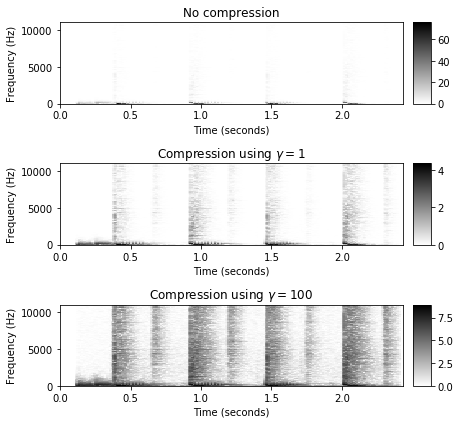

In [1]:
import os, sys
import numpy as np
from numba import jit
import librosa
from scipy import signal
from matplotlib import pyplot as plt
import IPython.display as ipd

sys.path.append('..')
import LibFMP.B
import LibFMP.C2
import LibFMP.C6

%matplotlib inline

fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.csv')
ann, label_keys = LibFMP.C6.read_annotation_pos(fn_ann)

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)
x_duration = len(x)/Fs
N, H = 1024, 256
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 1, 1]}, figsize=(6.5, 6))        

Y = np.abs(X)
LibFMP.B.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[0,0], ax[0,1]], title='No compression')

gamma = 1
Y = np.log(1 + gamma * np.abs(X))
LibFMP.B.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[1,0], ax[1,1]], title='Compression using $\gamma=%0.0f$'%gamma)

gamma = 100
Y = np.log(1 + gamma * np.abs(X))
LibFMP.B.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[2,0], ax[2,1]], title='Compression using $\gamma=%0.0f$'%gamma)
plt.tight_layout()

## Discrete Derivative, Half-Wave Rectification, Accumulation

In the next step, we compute the discrete temporal derivative of the compressed spectrum $\mathcal{Y}$. Similarly to the [energy-based novelty function](../C6/C6S1_NoveltyEnergy.html), we only consider the positive differences (increase in intensity) and discard negative ones by applying **half-wave rectification**. Finally we add up the positive differences over the frequency axis (**accumulation** step), which  yields the **spectral-based novelty function** $\Delta_\mathrm{Spectral}:\mathbb{Z}\to \mathbb{R}$: 

\begin{equation}
   \Delta_\mathrm{Spectral}(n):= \sum_{k=0}^K  \big|\mathcal{Y}(n+1,k)-\mathcal{Y}(n,k)\big|_{\geq 0}
\end{equation}

for $n\in\mathbb{Z}$. As for our Queen example, the resulting novelty curve nicely indicates the percussive beats (with high energy) as well as the low-energy hihat strokes in between.

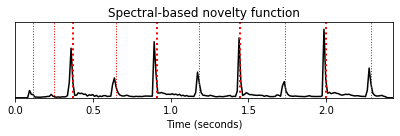

In [2]:
Y = np.log(1 + 100 * np.abs(X))
Y_diff = np.diff(Y, n=1)
Y_diff[Y_diff < 0] = 0
nov = np.sum(Y_diff, axis=0)
nov = np.concatenate((nov, np.array([0])))
Fs_nov = Fs/H

fig, ax, line = LibFMP.B.plot_signal(nov, Fs_nov, color='k', title='Spectral-based novelty function')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,  time_min=0, time_max=x_duration);

## Subtracting Local Average 

One can further enhance the properties of the novelty function by applying suitable postprocessing steps. For example, in view of a subsequent peak-picking step, one objective may be to enhance the peak structure of the novelty function, while suppressing small fluctuations. To this end, we introduce a local average
function $\mu:\mathbb{Z}\to\mathbb{R}$ by setting 

\begin{equation}
   \mu(n):= \frac{1}{2M+1}\sum_{m=-M}^M  \Delta_\mathrm{Spectral}(n+m),
\end{equation}

$n\in\mathbb{Z}$, where the parameter $M\in\mathbb{N}$ determines the size of an averaging window. The enhanced novelty function $\bar{\Delta}_\mathrm{Spectral}$ is obtained by subtracting the local average from $\Delta_\mathrm{Spectral}$ and by only keeping the positive part (half-wave rectification):

\begin{equation}
   \bar{\Delta}_\mathrm{Spectral}(n):= \big|\Delta_\mathrm{Spectral}(n)-\mu(n)\big|_{\geq 0}
\end{equation}

for $n\in\mathbb{Z}$. In the following implementation, we specify the length of the averaging window in seconds. Furthermore, we normalize the resulting novelty function by dividing it by its maximum value.

<!--The following figure illustrates the computational pipeline by means of our running example. 
<img src="../data/C6/FMP_C6_F06_text.png" width="500px" align="middle" alt="FMP_C6_F06_text.png">-->

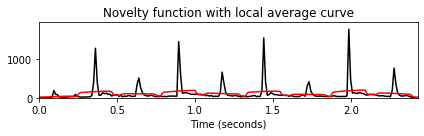

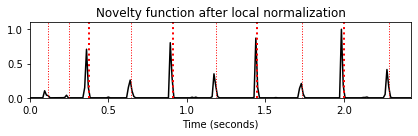

In [3]:
@jit(nopython=True)
def compute_local_average(x, M):
    """Compute local average of signal

    Notebook: C6/C6S1_NoveltySpectral.ipynb

    Args:
        x: Signal
        M: Determines size (2M+1) in samples of centric window  used for local average

    Returns:
        local_average: Local average signal
    """
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average

M_sec = 0.1
M = int(np.ceil(M_sec * Fs_nov))

local_average = compute_local_average(nov, M)
nov_norm =  nov - local_average
nov_norm[nov_norm<0]=0
nov_norm = nov_norm / max(nov_norm)

LibFMP.B.plot_signal(nov, Fs_nov, color='k', 
    title='Novelty function with local average curve');

t_novelty = np.arange(nov.shape[0]) / Fs_nov
plt.plot(t_novelty, local_average, 'r')
plt.tight_layout()

fig, ax, line = LibFMP.B.plot_signal(nov_norm, Fs_nov, color='k', 
                    title='Novelty function after local normalization')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

# %timeit compute_local_average(nov, M)

## Implementation

The following function implements the entire procedure, which is also included in `LibFMP`. To conclude this notebook, we compare the spectral-based novelty curve with the the [energy-based novelty curve](../C6/C6S1_NoveltyEnergy.html) using the Queen example.

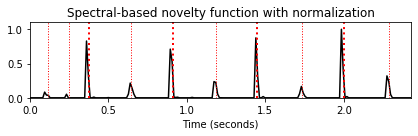

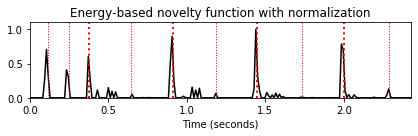

In [4]:
def compute_novelty_spectrum(x, Fs=1, N=1024, H=256, gamma=100, M=10, norm=1):
    """Compute spectral-based novelty function

    Notebook: C6/C6S1_NoveltySpectral.ipynb

    Args:
        x: Signal
        Fs: Sampling rate
        N: Window size
        H: Hope size
        gamma: Parameter for logarithmic compression
        M: Size (frames) of local average
        norm: Apply max norm (if norm==1)

    Returns:
        novelty_spectrum: Energy-based novelty function
        Fs_feature: Feature rate
    """
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs / H
    Y = np.log(1 + gamma * np.abs(X))
    Y_diff = np.diff(Y)
    Y_diff[Y_diff < 0] = 0
    novelty_spectrum = np.sum(Y_diff, axis=0)
    novelty_spectrum = np.concatenate((novelty_spectrum, np.array([0.0])))
    if M > 0:
        local_average = compute_local_average(novelty_spectrum, M)
        novelty_spectrum = novelty_spectrum - local_average
        novelty_spectrum[novelty_spectrum < 0] = 0.0
    if norm == 1:
        max_value = max(novelty_spectrum)
        if max_value > 0:
            novelty_spectrum = novelty_spectrum / max_value
    return novelty_spectrum, Fs_feature

nov, Fs_nov = compute_novelty_spectrum(x, Fs=Fs, N=1024, H=256, gamma=10, M=10, norm=1)
fig, ax, line = LibFMP.B.plot_signal(nov, Fs_nov, color='k', 
                    title='Spectral-based novelty function with normalization')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

nov, Fs_nov = LibFMP.C6.compute_novelty_energy(x, Fs=Fs, N=1024, H=256, gamma=10)
fig, ax, line = LibFMP.B.plot_signal(nov, Fs_nov, color='k',
                    title='Energy-based novelty function with normalization')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

## Further Notes

* In the [FMP notebook on onset detection](../C6/C6S1_OnsetDetection.html), one finds an introduction to the task of onset detection. 
* In the [FMP notebook on novelty comparison](../C6/C6S1_NoveltyComparison.html), we compare different novelty detection approaches.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Angel Villar-Corrales.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>